In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from scgenome import cncluster
from statannot import add_stat_annotation
from scdna_replication_tools.plot_utils import get_rt_cmap, get_clone_cmap, get_phase_cmap, plot_colorbar, make_color_mat_float, plot_cell_cn_profile2, plot_clustered_cell_cn_matrix

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 3
despine_trim = True

### Load and plot the replication state accuracy comparisons between PERT and Kronos

In [3]:
df_acc = pd.read_csv('scdna_replication_paper/analysis/simulation/all/scRT_accuracies.tsv', sep='\t')
# rename lambda column to avoid conflict with python keyword
df_acc.rename(columns={'lambda': 'lamb'}, inplace=True)
# rename entries that are method=='PERT comp.' to 'PERT'
df_acc.loc[df_acc['method'] == 'PERT comp.', 'method'] = 'PERT'
df_acc.head()

,dataset,datatag,alpha,lamb,beta0,beta1,cell_cna_rate,num_clones,method,rep_accuracy,cn_accuracy
0,D1.0,D1,10.0,0.75,1.2,0.0,0.0,1,Kronos,0.943182,NaN
1,D1.0,D1,10.0,0.75,1.2,0.0,0.0,1,PERT clone,0.997884,0.999987
2,D1.0,D1,10.0,0.75,1.2,0.0,0.0,1,PERT,0.997857,0.999991
3,D1.1,D1,10.0,0.75,1.2,0.0,0.0,1,Kronos,0.934858,NaN
4,D1.1,D1,10.0,0.75,1.2,0.0,0.0,1,PERT clone,0.997593,0.999977


In [4]:
def get_methods_cmap():
    cmap = {
        'PERT clone': 'olive',
        'PERT comp.': 'yellowgreen',
        'PERT': 'yellowgreen',
        'Kronos': 'lightcoral',
        'laks': 'darksalmon',
    }
    return cmap


# set the hue order to be the same for all plots
hue_order = ['PERT', 'Kronos']

In [5]:
def violins_with_pvals(df, x, y, hue, ax, box_pairs, test='t-test_ind', text_format='star', loc='inside', verbose=0, hue_order=None):
    """ Create a violinplot with p-values annotated. """
    palette = get_methods_cmap()
    sns.boxplot(data=df, x=x, y=y, hue=hue, ax=ax, palette=palette, linewidth=0.5, fliersize=1, hue_order=hue_order)
    add_stat_annotation(ax, data=df, x=x, y=y, hue=hue,
                        box_pairs=box_pairs, test=test,
                        text_format=text_format, loc=loc, verbose=verbose, hue_order=hue_order)


def plot_cna_rate_rep_acc(df, ax, n=1, test='t-test_ind', text_format='star', loc='inside', verbose=0, hue_order=None):
    ''' Plot the replications state accuracy vs cna rate at a fixed number of clones (n). '''
    x = "cell_cna_rate"
    y = "rep_accuracy"
    hue = "method"
    temp_df = df.query('alpha==10.0').query('lamb==0.75').query('num_clones=={}'.format(n)).query('beta0==1.2')
    box_pairs = [
        ((0.05, "Kronos"), (0.05, "PERT")),
        ((0.02, "Kronos"), (0.02, "PERT")),
        ((0.00, "PERT"), (0.00, "Kronos")),
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test, text_format=text_format, loc=loc, verbose=verbose, hue_order=hue_order)
    ax.set_title('Sweep across cell CNA rate\n# of clones={}'.format(n))
    ax.set_xlabel('cell CNA rate')
    ax.set_ylabel('replication state accuracy')
    # show the legend in the bottom left corner
    ax.legend(loc='lower left', frameon=False)
    return ax


def plot_clone_effect_rep_acc(df, ax, rate=0.02, test='t-test_ind', text_format='star', loc='inside', verbose=0, hue_order=None):
    ''' Plot the replication accuracy vs number of clones at a fixed cell cna rate. '''
    x = "num_clones"
    y = "rep_accuracy"
    hue = "method"
    temp_df = df.query('alpha==10.0').query('lamb==0.75').query('cell_cna_rate=={}'.format(rate)).query('num_clones<4').query('beta0==1.2')
    box_pairs = [
        ((3, "Kronos"), (3, "PERT")),
        ((1, "Kronos"), (1, "PERT")),
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test,
                       text_format=text_format, loc=loc, verbose=verbose, hue_order=hue_order)
    ax.set_title('Sweep across # of clones\ncell CNA rate={}'.format(rate))
    ax.set_xlabel('# of clones')
    ax.set_ylabel('replication state accuracy')
    # turn off the legend
    ax.legend().set_visible(False)
    return ax


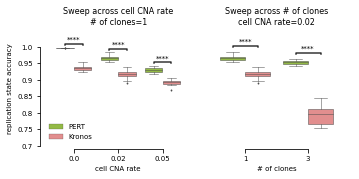

In [6]:
def plot_simulated_rep_accuracies(df_acc, axes):
    '''Plot a sweep across the cell cna rate on the left (n=1) and a sweep across the number of clones on the right (rate=0.02)''' 
    plot_cna_rate_rep_acc(df_acc, axes[0], n=1, hue_order=hue_order, loc='inside')
    plot_clone_effect_rep_acc(df_acc, axes[1], rate=0.02, hue_order=hue_order, loc='inside')

    # reset the y-limits of both subplots to be the max and min of each
    min_ylim = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
    max_ylim = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
    axes[0].set_ylim(min_ylim, max_ylim)
    axes[1].set_ylim(min_ylim, max_ylim)

    # remove any ticks or tick-labels that are >1 from both y-axes
    yticks = axes[0].get_yticks()
    yticks = [a for a in yticks if a <= 1]
    yticklabels = [str(a.round(2)) for a in yticks]
    axes[0].set_yticks(yticks)
    axes[0].set_yticklabels(yticklabels)
    axes[1].set_yticks(yticks)
    axes[1].set_yticklabels(yticklabels)

    # despine both the subplots
    sns.despine(ax=axes[0], offset=despine_offset, trim=despine_trim)
    sns.despine(ax=axes[1], offset=despine_offset, trim=despine_trim)

    # hide the y-axis ticks, tick-labels, and spine for the right subplot
    # this needs to be after despining so that the data stays on the same scale as the left subplot
    axes[1].set_yticks([])
    axes[1].set_yticklabels([])
    axes[1].spines['left'].set_visible(False)
    axes[1].set_ylabel('')

fig, axes = plt.subplots(1, 2, figsize=(5, 2.5), sharey=False, tight_layout=True)
plot_simulated_rep_accuracies(df_acc, axes)
plt.show()

### Load and plot the phase accuracy of PERT

In [7]:
df_phase = pd.read_csv('scdna_replication_paper/analysis/simulation/all/phase_accuracies.tsv', sep='\t')

df_phase['PERT_phase'] = df_phase['PERT_phase'].astype(str)
df_phase['true_phase'] = df_phase['true_phase'].astype(str)
df_phase['laks_phase'] = df_phase['laks_phase'].astype(str)
df_phase['cell_id'] = df_phase['cell_id'].astype(str)

# rename the lambda column to lambd to avoid conflict with python keyword
df_phase.rename(columns={'lambda': 'lamb'}, inplace=True)

# melt `PERT_phase_acc` and `laks_phase_acc` into a single column `phase_acc`
# and 'PERT_phase' and 'laks_phase' into a single column `pred_phase`
# where the method is noted in a new column `method`
df_phase = pd.melt(df_phase, 
    id_vars=[col for col in df_phase.columns if not col.endswith('_phase_acc')],
    value_vars=['PERT_phase_acc', 'laks_phase_acc'], var_name='method', value_name='phase_acc')

# rename the method column to remove the '_phase_acc' suffix
df_phase['method'] = df_phase['method'].str.replace('_phase_acc', '')

# create a new column named 'predicted_phase' that is the same as 'PERT_phase' if 'method' is 'PERT', 'laks_phase' if the method is 'laks'
df_phase['predicted_phase'] = np.where(df_phase['method'] == 'PERT', df_phase['PERT_phase'], df_phase['laks_phase'])

print(df_phase[['cell_id', 'method', 'true_phase', 'predicted_phase']].head())

# create a new column named 'phase_class' which says whether the 
# given prediction is a true positive, false positive, true negative, or false negative
df_phase['phase_class'] = 'None'
for i, row in df_phase.iterrows():
    if row['predicted_phase'] == row['true_phase'] and row['true_phase'] == 'S':
        df_phase.at[i, 'phase_class'] = 'TP'
    elif row['predicted_phase'] == row['true_phase'] and row['true_phase'] == 'G1/2':
        df_phase.at[i, 'phase_class'] = 'TN'
    elif row['predicted_phase'] != row['true_phase'] and row['true_phase'] == 'S':
        df_phase.at[i, 'phase_class'] = 'FN'
    elif row['predicted_phase'] != row['true_phase'] and row['true_phase'] == 'G1/2':
        df_phase.at[i, 'phase_class'] = 'FP'

print(df_phase[['cell_id', 'method', 'true_phase', 'predicted_phase', 'phase_class']])
print(df_phase.phase_class.value_counts())

# drop the pert_phase and laks_phase columns
df_phase.drop(columns=['PERT_phase', 'laks_phase'], inplace=True)

# fill missing true_cell_frac_rep values with 0.0 as these are G1/2 cells with no replicated bins
df_phase['true_cell_frac_rep'].fillna(0.0, inplace=True)

# rename 'LowQual' entries in the 'predicted_phase' column to 'LQ'
df_phase['predicted_phase'] = df_phase['predicted_phase'].str.replace('LowQual', 'LQ')

df_phase.head()

      cell_id method true_phase predicted_phase
0    cell_S_0   PERT          S               S
1    cell_S_1   PERT          S               S
2   cell_S_10   PERT          S               S
3  cell_S_100   PERT          S               S
4  cell_S_101   PERT          S               S
           cell_id method true_phase predicted_phase phase_class
0         cell_S_0   PERT          S               S          TP
1         cell_S_1   PERT          S               S          TP
2        cell_S_10   PERT          S               S          TP
3       cell_S_100   PERT          S               S          TP
4       cell_S_101   PERT          S               S          TP
...            ...    ...        ...             ...         ...
307195   cell_G_79   laks       G1/2            G1/2          TN
307196   cell_G_81   laks       G1/2            G1/2          TN
307197   cell_G_88   laks       G1/2            G1/2          TN
307198   cell_G_95   laks       G1/2            G1/2          

,cell_id,true_phase,true_cell_frac_rep,cell_frac_rep,datatag,dataset,alpha,lamb,beta0,beta1,cell_cna_rate,num_clones,method,phase_acc,predicted_phase,phase_class
0,cell_S_0,S,0.083287,0.078291,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP
1,cell_S_1,S,0.100715,0.094510,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP
2,cell_S_10,S,0.176848,0.163755,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP
3,cell_S_100,S,0.810677,0.804117,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP
4,cell_S_101,S,0.594019,0.570805,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP


In [8]:
def plot_time_jointplot(df, ax_scatter, ax_hist, pt_size=5):
    ''' Plot a jointplot of the PERT and true fraction of replicated bins per cell. Use the phase class (TP, FP, TN, FN) as the hue. '''
    # subset to just the rows with method=='PERT'
    df = df.query('method=="PERT"').query('lamb==0.75')
    # phase_class_pal = {'TP': 'green', 'TN': 'blue', 'FP': 'red', 'FN': 'orange'}
    pal = get_phase_cmap()
    # plot a scatterplot of the true and inferred fraction of replicated bins per cell
    sns.scatterplot(data=df, x='true_cell_frac_rep', y='cell_frac_rep', hue='true_phase', palette=pal, ax=ax_scatter, s=pt_size, alpha=0.2, rasterized=True)
    ax_scatter.set_xlabel('true time')
    ax_scatter.set_ylabel('PERT time')
    ax_scatter.legend(title='true phase')

    # plot a histogram of the inferred fraction of replicated bins per cell along the y-axis
    sns.histplot(data=df, y='cell_frac_rep', hue='true_phase', palette=pal, ax=ax_hist, kde=False, bins=20, common_norm=False)
    ax_hist.set_ylabel('')
    ax_hist.legend().set_visible(False)


def plot_confusion_matrix(df, ax):
    ''' Given a table of true and inferred phases, plot a confusion matrix with counts of each cell in each phase '''
    # subset to just the rows with method=='PERT'
    df = df.query('method=="PERT"').query('lamb==0.75')
    # Plot confusion matrix
    sns.heatmap(pd.crosstab(df['predicted_phase'], df['true_phase']), annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False)
    ax.set_xlabel('true phase')
    ax.set_ylabel('PERT phase')
    # center the y-axis tick labels
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')
    ax.set_title('All simulated cells (lambda=0.75)')


### Load and plot the simulated data and PERT results for simulated dataset P5.8

In [22]:
dataset = 'P8.4'
true_frac_col = 'true_cell_frac_rep'
model_rep_state = 'model_rep_state'
true_rep_state = 'true_rep'
model_cn_state = 'model_cn_state'
true_cn_state = 'true_G1_state'
reads_col = 'reads'
clone_col = 'clone_id'
time_col = 'true_t'

cn_s_sim = pd.read_csv('scdna_replication_paper/analysis/simulation/{}/s_phase_cells_pyro_composite_filtered.tsv'.format(dataset), sep='\t')
cn_g_sim = pd.read_csv('scdna_replication_paper/analysis/simulation/{}/g1_phase_cells_pyro_composite_filtered.tsv'.format(dataset), sep='\t')

# set chr column to category
cn_s_sim.chr = cn_s_sim.chr.astype(str).astype('category')
cn_g_sim.chr = cn_g_sim.chr.astype(str).astype('category')

cn_s_sim.head()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (52) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,cell_id,chr,start,end,reads,gc,map,copy,state,multiplier,...,extreme_cell_frac,cell_frac_rep,rpm_auto,rep_auto,cn_bk,rep_bk,frac_cn0,rpm_auto_norm,rep_auto_norm,PERT_phase
0,cell_S_0,1,2000000,2500000,416,0.594508,0.997066,0.994323,1,1,...,False,0.469432,0.423301,0.028514,7,870,0.0,-0.183455,NaN,S
1,cell_S_0,1,4500000,5000000,197,0.481828,0.999002,0.831137,1,1,...,False,0.469432,0.423301,0.028514,7,870,0.0,-0.183455,NaN,S
2,cell_S_0,1,6500000,7000000,395,0.489968,0.999179,1.597702,2,1,...,False,0.469432,0.423301,0.028514,7,870,0.0,-0.183455,NaN,S
3,cell_S_0,1,7500000,8000000,334,0.488250,0.998566,1.363050,2,1,...,False,0.469432,0.423301,0.028514,7,870,0.0,-0.183455,NaN,S
4,cell_S_0,1,8000000,8500000,372,0.462702,0.998576,1.731678,2,1,...,False,0.469432,0.423301,0.028514,7,870,0.0,-0.183455,NaN,S


In [23]:
cn_s_sim.shape, cn_g_sim.shape

((1086834, 69), (1356138, 69))

In [35]:
# subset cn_g_sim and cn_s_sim to just chromosomes 3-5
cn_s_sim = cn_s_sim.query('chr in ["15", "16", "18"]')
cn_g_sim = cn_g_sim.query('chr in ["15", "16", "18"]')
cn_g_sim['chr'].unique()

['15', '16', '18']
Categories (23, object): ['1', '10', '11', '12', ..., '7', '8', '9', 'X']

In [36]:
cn_s_sim.shape, cn_g_sim.shape

((87462, 69), (109134, 69))

In [37]:
# print the number of unique cells in each clone
print(cn_s_sim[['cell_id', 'clone_id']].drop_duplicates().clone_id.value_counts())
print(cn_g_sim[['cell_id', 'clone_id']].drop_duplicates().clone_id.value_counts())

A    135
B    120
C     84
Name: clone_id, dtype: int64
A    161
C    134
B    128
Name: clone_id, dtype: int64


In [38]:
s_clone_counts = {'A': 8, 'C': 12}
g_clone_counts = {'A': 10, 'C': 10}

# subset cn_s_sim to only have a certain amount of cells in each clone
# use the clone counts defined above to determine how many cells to keep for each clone
cn_s_sim2 = []
for clone_id, clone_count in s_clone_counts.items():
    clone_cn = cn_s_sim.query('clone_id == "{}"'.format(clone_id))
    i = 0
    for cell_id, cell_cn in clone_cn.groupby('cell_id'):
        cn_s_sim2.append(cell_cn)
        i += 1
        if i == clone_count:
            break
cn_s_sim2 = pd.concat(cn_s_sim2, ignore_index=True)

# repeat for cn_g_sim
cn_g_sim2 = []
for clone_id, clone_count in g_clone_counts.items():
    clone_cn = cn_g_sim.query('clone_id == "{}"'.format(clone_id))
    i = 0
    for cell_id, cell_cn in clone_cn.groupby('cell_id'):
        cn_g_sim2.append(cell_cn)
        i += 1
        if i == clone_count:
            break
cn_g_sim2 = pd.concat(cn_g_sim2, ignore_index=True)

# print the number of unique cells in each clone
print(cn_s_sim2[['cell_id', 'clone_id']].drop_duplicates().clone_id.value_counts())
print(cn_g_sim2[['cell_id', 'clone_id']].drop_duplicates().clone_id.value_counts())

C    12
A     8
Name: clone_id, dtype: int64
A    10
C    10
Name: clone_id, dtype: int64


In [39]:
cn_s_sim2.shape, cn_g_sim2.shape

((5160, 69), (5160, 69))

In [49]:
cn_g_sim2.true_phase.value_counts()

G1/2    5160
Name: true_phase, dtype: int64

In [50]:
# concatenate cn_s_sim and cn_g_sim into one dataframe
cn_sim = pd.concat([cn_s_sim2, cn_g_sim2], ignore_index=True)
cn_sim['phase'] = cn_sim['true_phase'].map({'S': 1, 'G1/2': 0})

cn_sim[['cell_id', 'phase', 'clone_id']].drop_duplicates()[['phase', 'clone_id']].value_counts()

phase  clone_id
1      C           12
0      A           10
       C           10
1      A            8
dtype: int64

In [51]:
cn_sim.columns

Index(['cell_id', 'chr', 'start', 'end', 'reads', 'gc', 'map', 'copy', 'state',
       'multiplier', 'autocorrelation_hmmcopy', 'mean_hmmcopy_reads_per_bin',
       'std_hmmcopy_reads_per_bin', 'total_mapped_reads_hmmcopy',
       'total_halfiness', 'scaled_halfiness', 'breakpoints', 'mean_copy',
       'mcf7_rt', 'bg02es_rt', 'bj_rt', 'gm06990_rt', 'gm12801_rt',
       'gm12812_rt', 'gm12813_rt', 'gm12878_rt', 'helas3_rt', 'hepg2_rt',
       'huvec_rt', 'imr90_rt', 'k562_rt', 'sknsh_rt', 'nhek_rt', 'bin_size',
       'clone_id', 'clone_cn_state', 'true_G1_state', 'library_id',
       'true_reads_norm', 'true_reads_raw', 'true_rep', 'true_p_rep', 'true_t',
       'observed_cn_state', 'true_cell_frac_rep', 'madn', 'lrs',
       'corrected_madn', 'corrected_breakpoints', 'laks_is_s_phase',
       'laks_is_s_phase_prob', 'laks_phase', 'assigned_clone_id',
       'model_cn_state', 'model_rep_state', 'model_tau', 'model_u',
       'model_rho', 'true_phase', 'extreme_cell_frac', 'cell_frac_r

In [67]:
def plot_pert_IO_heatmaps(
    df,
    ax_reads_heatmap,
    ax_cn_heatmap,
    ax_rep_heatmap,
    ax_clone_cn=None,
    ax_clone_rep=None,
    ax_phase_cn=None,
    ax_phase_rep=None,
    ax_time_cn=None,
    ax_time_rep=None,
    time_col='true_cell_frac_rep',
    model_rep_state='model_rep_state',
    true_rep_state='true_rep',
    model_cn_state='model_cn_state',
    true_cn_state='true_G1_state',
    clone_col='clone_id',
    reads_col='true_reads_norm',
    phase_col='phase',
    rt_cmap=get_rt_cmap(),
    phase_cmap=get_phase_cmap()
):
    """ 
    Plot heatmaps of true and inferred replication and copy states, as well as false positive/negative calls and input read depth.
    All rows of each heatmap are sorted by clone id and the true time in S-phase.
    """
    # create mapping of clones to cluster ids
    cluster_col = 'cluster_id'
    clone_dict = dict([(y,x+1) for x,y in enumerate(sorted(df[clone_col].unique()))])
    df[cluster_col] = df[clone_col]
    df = df.replace({cluster_col: clone_dict})

    # note which columns to sort by
    secondary_sort_column = time_col
    chrom_labels_to_remove = ['15', '16', '17', '18']

    # top left: true CN state
    plot_data0 = plot_clustered_cell_cn_matrix(
        ax_reads_heatmap, df, reads_col, chrom_boundary_width=0.5, raw=True, cmap='viridis', max_cn=None,
        vmin=np.percentile(df[reads_col].values, 10), vmax=np.percentile(df[reads_col].values, 90),
        chrom_labels_to_remove=chrom_labels_to_remove
    )
    ax_reads_heatmap.set_title('Read depth')

    # top right: inferred CN state
    plot_data1 = plot_clustered_cell_cn_matrix(
        ax_cn_heatmap, df, true_cn_state, cluster_field_name=cluster_col, secondary_field_name=secondary_sort_column, 
        chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )
    ax_cn_heatmap.set_title('Somatic CN states')

    # bottom left: true replication state
    plot_data2 = plot_clustered_cell_cn_matrix(
        ax_rep_heatmap, df, true_rep_state, cluster_field_name=cluster_col, secondary_field_name=secondary_sort_column, 
        cmap=rt_cmap, chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )
    ax_rep_heatmap.set_title('Replication states')

    # hide the y-ticks and labels for all heatmaps
    for ax in [ax_reads_heatmap, ax_rep_heatmap, ax_cn_heatmap, ax_clone_cn, ax_clone_rep, ax_phase_cn, ax_phase_rep, ax_time_cn, ax_time_rep]:
        if ax is not None:
            ax.set_yticks([])
            ax.set_yticklabels([])
    
    if len(clone_dict) > 1:
        # annotate the clones for G1-phase cells
        cell_ids = plot_data1.columns.get_level_values(0).values
        cluster_ids0 = plot_data1.columns.get_level_values(1).values
        clone_cmap = get_clone_cmap()
        # use mcolors to change every element in the dict to rgba
        for key in clone_cmap.keys():
            clone_cmap[key] = mcolors.to_rgba(clone_cmap[key])
        color_mat0, color_map0 = cncluster.get_cluster_colors(cluster_ids0, color_map=clone_cmap, return_map=True)

        # get list of color pigments in the same order as clone_dict
        colors_used0 = []
        for c in color_mat0:
            if c not in colors_used0:
                colors_used0.append(c)

        # match clone IDs to color pigments
        clones_to_colors0 = {}
        for i, key in enumerate(clone_dict.keys()):
            clones_to_colors0[key] = colors_used0[i]
        
        # get array of the site values that match the cell_id order
        condensed_cn = df[['cell_id', phase_col]].drop_duplicates()
        phase_array = []
        for cell in cell_ids:
            phase = condensed_cn[condensed_cn['cell_id'] == cell][phase_col].values[0]
            phase_array.append(phase)
        
        # use mcolors to change every element of the site cmap dict to rgba
        for key in phase_cmap.keys():
            phase_cmap[key] = mcolors.to_rgba(phase_cmap[key])
        phase_color_mat, _ = cncluster.get_cluster_colors(phase_array, color_map=phase_cmap, return_map=True)

        # get array of secondary_sort_column values that that match the cell_id order
        condensed_cn = df[['cell_id', secondary_sort_column]].drop_duplicates()
        secondary_array = []
        for cell in cell_ids:
            s = condensed_cn[condensed_cn['cell_id'] == cell][secondary_sort_column].values[0]
            secondary_array.append(s)

        # make color mat according to secondary array
        secondary_color_mat, secondary_to_colors = make_color_mat_float(secondary_array, 'Blues')

        # plot a color bar corresponding to clone ID
        if ax_clone_cn is not None:
            plot_colorbar(ax_clone_cn, color_mat0)
            ax_clone_cn.set_xticks([0.0])
            ax_clone_cn.set_xticklabels(['clone'], rotation=90)

        # create color bar that shows secondary sort value for each row in heatmap
        if ax_phase_cn is not None:
            plot_colorbar(ax_phase_cn, phase_color_mat)
            ax_phase_cn.set_xticks([0.0])
            ax_phase_cn.set_xticklabels(['phase'], rotation=90)

        # plot a color bar corresponding to secondary_sort_column
        if ax_time_cn is not None:
            plot_colorbar(ax_time_cn, secondary_color_mat)
            ax_time_cn.set_xticks([0.0])
            ax_time_cn.set_xticklabels(['time'], rotation=90)

        # add the same color bars for the replication heatmaps since the cells are sorted in the same order
        if ax_clone_rep is not None:
            plot_colorbar(ax_clone_rep, color_mat0)
        if ax_phase_rep is not None:
            plot_colorbar(ax_phase_rep, phase_color_mat)
        if ax_time_rep is not None:
            plot_colorbar(ax_time_rep, secondary_color_mat)

    ax_reads_heatmap.set_ylabel('{} total cells'.format(df.cell_id.nunique()))
    ax_cn_heatmap.set_xlabel('genomic loci')
    ax_reads_heatmap.set_xlabel('genomic loci')



/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


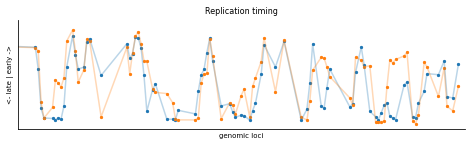

In [68]:
import matplotlib

def plot_example_rt_profiles(
    ax,
    df,
    rt_cols=['model_rho'],
    labels=['A'],
    colors=['C0'],
    chromosome='18',
    s=5
    ):
    for rt_col, label, color in zip(rt_cols, labels, colors):
        temp_df = df[['chr', 'start', 'end', rt_col]].drop_duplicates().reset_index(drop=True)
        plot_cell_cn_profile2(ax, temp_df, rt_col, cn_field_name=None, max_cn=None,
                            chromosome=chromosome, s=s, squashy=False, color=color, alpha=1, rawy=True,
                            lines=True, label=label, scale_data=True, rasterized=True,
                            chrom_labels_to_remove=[])
    ax.set_title('Replication timing')
    ax.set_ylabel('<- late | early ->')
    # remove all major and minor tick labels from the x and y axes
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator([]))

    ax.set_xlabel('genomic loci')
    if None not in labels:
        ax.legend()
    
    sns.despine(ax=ax, offset=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 2))
plot_example_rt_profiles(ax, cn_s_sim, rt_cols=['mcf7_rt', 'bj_rt'], labels=['A', None], colors=['C0', 'C1'])

plt.show()

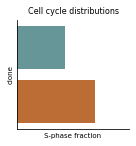

In [69]:
def plot_demo_spf(ax):
    clones = ['A', 'B']
    cmap = get_clone_cmap()
    spfs = [0.17, 0.28]
    df = pd.DataFrame({'clone': clones, 'spf': spfs})
    sns.barplot(x='spf', y='clone', data=df, palette=cmap, ax=ax)
    ax.set_xlabel('S-phase fraction')
    ax.set_ylabel('clone')
    ax.set_xlim([0, 0.4])
    ax.set_title('Cell cycle distributions')
    sns.despine(ax=ax, offset=0, trim=False)
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticklabels([])
    ax.set_yticks([])

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
plot_demo_spf(ax)
plt.show()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/scdna_replication_tools/plot_utils.py:232: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete')
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.


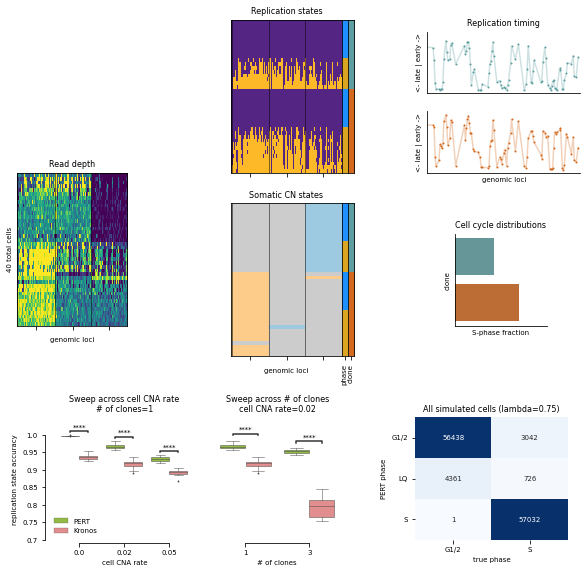

In [70]:
# create a large 8.5 x 11 figure and manually add all the subplots with custom positioning
# since I'm adding labels the figure will be slightly larger than the specified size,
# thus I need to divide the width and height by a multiplicative factor to get the correct size
mult_factor = 1.0
fig = plt.figure(figsize=(8.5/mult_factor, 8.5/mult_factor))

# heatmap in left upper-middle corner showing heatmap of read depth
ax0 = fig.add_axes([0.05, 0.45, 0.18, 0.25])

# put a heatmap to the right of ax0 that's above ax0 and has the same width and height
ax1 = fig.add_axes([0.4, 0.7, 0.18, 0.25])
ax1.set_title('ax1')
ax2 = fig.add_axes([0.59, 0.7, 0.01, 0.25])
ax2a = fig.add_axes([0.58, 0.7, 0.01, 0.25])
# ax9 = fig.add_axes([0.38, 0.7, 0.01, 0.25])
# ax10 = fig.add_axes([0.37, 0.7, 0.01, 0.25])

# put a heatmap below ax1 that has the same width and height
ax3 = fig.add_axes([0.4, 0.4, 0.18, 0.25])
ax3.set_title('ax3')
ax4 = fig.add_axes([0.59, 0.4, 0.01, 0.25])
ax4a = fig.add_axes([0.58, 0.4, 0.01, 0.25])
# ax12 = fig.add_axes([0.38, 0.4, 0.01, 0.25])
# ax13 = fig.add_axes([0.37, 0.4, 0.01, 0.25])

# put a wide but short heatmap to the right of ax1 to show the learned RT profile
# ax5 = fig.add_axes([0.72, 0.775, 0.25, 0.1])
# ax5.set_title('ax5')

ax5a = fig.add_axes([0.72, 0.83, 0.25, 0.1])
ax5b = fig.add_axes([0.72, 0.7, 0.25, 0.1])

# put a square subplot to the right of ax2 to show the cell cycle fractions of each clone
ax6 = fig.add_axes([0.765, 0.45, 0.15, 0.15])
ax6.set_title('ax6')

# put 4 subplots in the bottom row showing results summarizing simuation benchmarking
ax7 = fig.add_axes([0.1, 0.1, 0.25, 0.2])
# ax5.set_title('ax7')
ax8 = fig.add_axes([0.35, 0.1, 0.25, 0.2])
# ax6.set_title('ax8')
ax9 = fig.add_axes([0.7, 0.1, 0.25, 0.2])
# ax7.set_title('ax9')


# plot the replication state accuracy vs cell cna rate and number of clones
plot_simulated_rep_accuracies(df_acc, [ax7, ax8])

# plot the phase accuracy jointplot and confusion matrix
plot_confusion_matrix(df_phase, ax9)

plot_pert_IO_heatmaps(
    cn_sim,
    ax0,
    ax3,
    ax1,
    ax_clone_cn=ax4,
    ax_clone_rep=ax2,
    ax_phase_cn=ax4a,
    ax_phase_rep=ax2a
)

# plot two example RT profiles to the right of the replication state heatmap
# plot_example_rt_profiles(
#     ax5, cn_s_sim, 
#     rt_cols=['mcf7_rt', 'bj_rt'], 
#     labels=['A', None], 
#     colors=[get_clone_cmap()['A'], get_clone_cmap()['B']], 
#     s=1
# )
plot_example_rt_profiles(
    ax5a, cn_s_sim, 
    rt_cols=['mcf7_rt'], 
    labels=[None], 
    colors=[get_clone_cmap()['A']], 
    s=1
)
plot_example_rt_profiles(
    ax5b, cn_s_sim, 
    rt_cols=['bj_rt'], 
    labels=[None], 
    colors=[get_clone_cmap()['B']], 
    s=1
)
ax5b.set_title('')
ax5a.set_xlabel('')

# plot a diagram showing a comparison of S-phase fractions in ax4
plot_demo_spf(ax6)

fig.savefig('scdna_replication_paper/manuscript/main_figs/fig1.pdf', bbox_inches='tight', dpi=300)

# draw a dashed lines around the boundaries of the entire figure to know where to crop
# ax_bottom = fig.add_axes([0, 0, 1, 0.01])
# ax_top = fig.add_axes([0, 0.99, 1, 0.01])
# ax_left = fig.add_axes([0, 0, 0.01, 1])
# ax_right = fig.add_axes([0.99, 0, 0.01, 1])
# for ax in [ax_bottom, ax_top, ax_left, ax_right]:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

plt.show()